In [1]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from tqdm import tqdm

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch


import cv2
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

/Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: <0B637046-A38B-3A5C-80C6-E847C27DCCD5> /Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <BB02660F-1D5B-3388-B48B-486877D726F6> /Users/tylerskowtyler/opt/miniconda3/envs/av

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
        'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
        'teddy bear', 'hair drier', 'toothbrush']

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    # plt.show()

In [3]:
rotation_max=0.0
scale_min=0.1
scale_max=0.3
distortion_scale_max=0.0
learning_rate=1.99
max_iter=200
batch_size=16
patch_shape=(3, 640, 640)
patch_location=None
patch_type="circle"
optimizer="pgd"

In [22]:
MODEL = 'yolov3' # OR yolov5


if MODEL == 'yolov3':

    from pytorchyolo.utils.loss import compute_loss
    from pytorchyolo.models import load_model

    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model(x)
                loss, loss_components = compute_loss(outputs, targets, self.model)
                loss_components_dict = {"loss_total": loss}
                loss_components_dict['loss_box'] = loss_components[0]
                loss_components_dict['loss_obj'] = loss_components[1]
                loss_components_dict['loss_cls'] = loss_components[2]
                return loss_components_dict
            else:
                tmp = self.model(x)
                return tmp

    model_path = "./yolov3.cfg"
    weights_path = "./yolov3.weights"
    model = load_model(model_path=model_path, weights_path=weights_path)
            
    model = Yolo(model)

    detector = PyTorchYolo(model=model,
                        device_type='cpu',
                        input_shape=(3, 640, 640),
                        clip_values=(0, 255), 
                        attack_losses=("loss_total", "loss_cls",
                                        "loss_box",
                                        "loss_obj"))

elif MODEL == 'yolov5':

    import yolov5
    from yolov5.utils.loss import ComputeLoss

    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.model.hyp = {'box': 0.05,
                            'obj': 1.0,
                            'cls': 0.5,
                            'anchor_t': 4.0,
                            'cls_pw': 1.0,
                            'obj_pw': 1.0,
                            'fl_gamma': 0.0
                            }
            self.compute_loss = ComputeLoss(self.model.model.model)

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model.model.model(x)
                loss, loss_items = self.compute_loss(outputs, targets)
                loss_components_dict = {"loss_total": loss}
                loss_components_dict['loss_box'] = loss_items[0]
                loss_components_dict['loss_obj'] = loss_items[1]
                loss_components_dict['loss_cls'] = loss_items[2]
                return loss_components_dict
            else:
                return self.model(x)

    model = yolov5.load('yolov5s.pt')
    
    model = Yolo(model)

    detector = PyTorchYolo(model=model,
                        device_type='cpu',
                        input_shape=(3, 640, 640),
                        clip_values=(0, 255), 
                        attack_losses=("loss_total", "loss_cls",
                                        "loss_box",
                                        "loss_obj"))


In [23]:
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 640, 640)

transform = transforms.Compose([
        transforms.Resize(INPUT_SHAPE[1], interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(INPUT_SHAPE[1]),
        transforms.ToTensor()
    ])

urls = ['http://images.cocodataset.org/val2017/000000039769.jpg',
'http://images.cocodataset.org/val2017/000000397133.jpg',
'http://images.cocodataset.org/val2017/000000037777.jpg',
'http://images.cocodataset.org/val2017/000000454661.jpg',
'http://images.cocodataset.org/val2017/000000094852.jpg']
coco_images = []
for url in urls:
    im = Image.open(requests.get(url, stream=True).raw)
    im = transform(im).numpy()
    coco_images.append(im)
coco_images = np.array(coco_images)*255

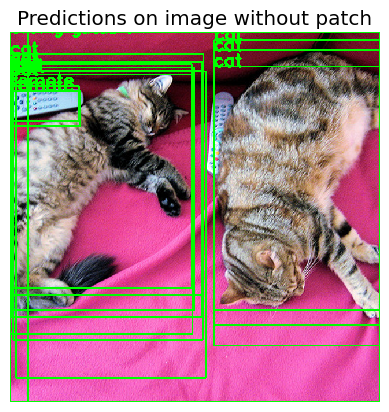

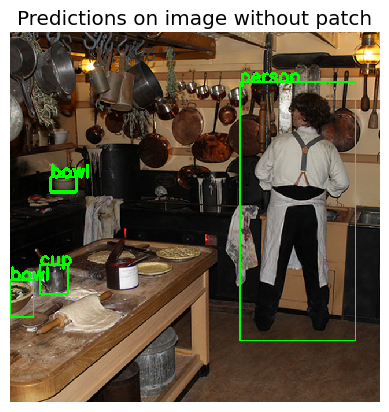

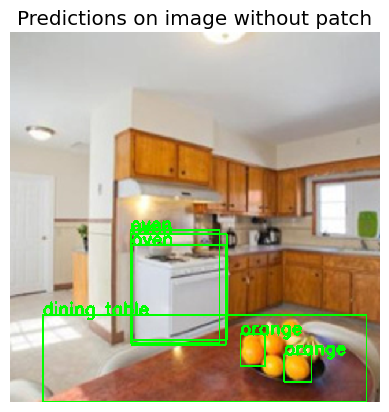

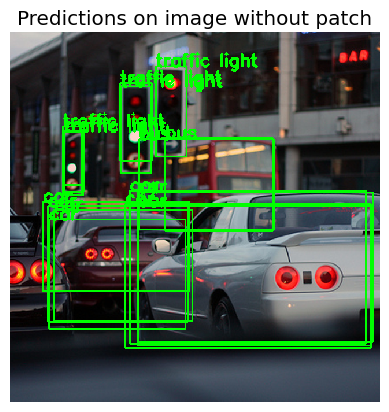

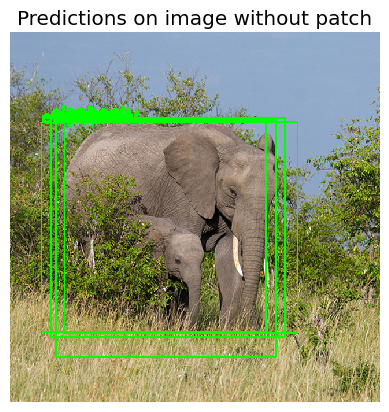

In [25]:
%matplotlib inline
dets = detector.predict(coco_images) 
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    plot_image_with_boxes(img=coco_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Predictions on image without patch")


In [26]:
import numpy as np

def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    # Filter boxes by confidence threshold
    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][i])  # Removed extra brackets around [i]
            labels_list.append(predictions[0]["labels"][i])  # Removed extra brackets around [i]

    # Ensure each list has data; otherwise, return an empty array
    dictionary["boxes"] = np.vstack(boxes_list) if boxes_list else np.empty((0, 4))  # Assuming boxes have 4 coordinates
    dictionary["scores"] = np.hstack(scores_list) if scores_list else np.empty((0,))
    dictionary["labels"] = np.hstack(labels_list) if labels_list else np.empty((0,))

    y = [dictionary]

    return y

# Apply the filter_boxes function to each detection in dets
y = [filter_boxes([t], 0.8)[0] for t in dets]


Adversarial Patch PyTorch:   0%|          | 0/10 [00:00<?, ?it/s]/Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/Users/tylerskowtyler/opt/miniconda3/envs/avlm/lib/python3.10/site-packages/torchvision/transforms/functional.py:724: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Adversarial Patch PyTorch: 100%|██████████| 10/10 [03:49<00:00, 22.99s/it]


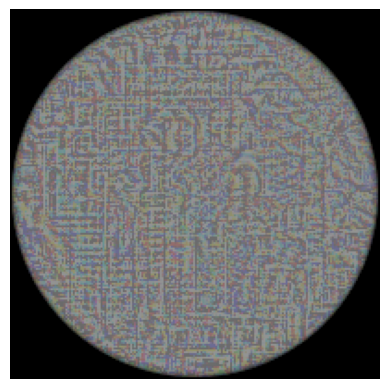

In [27]:
ap = AdversarialPatchPyTorch(estimator=detector, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max, optimizer=optimizer, distortion_scale_max=distortion_scale_max,
                      learning_rate=learning_rate, max_iter=10, batch_size=batch_size,
                      patch_shape=(3, 200, 200), patch_type=patch_type, verbose=True, targeted=True)

patch, patch_mask = ap.generate(x=coco_images[:-1], y=[y[-1] for i in range(len(coco_images[:-1]))])

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0).astype(np.uint8))
plt.show()


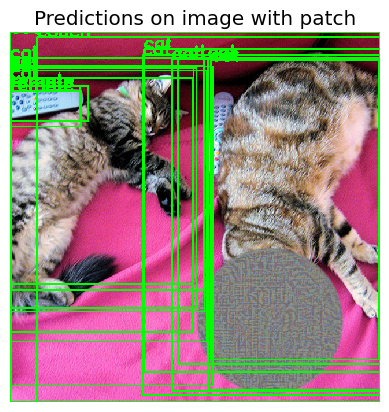

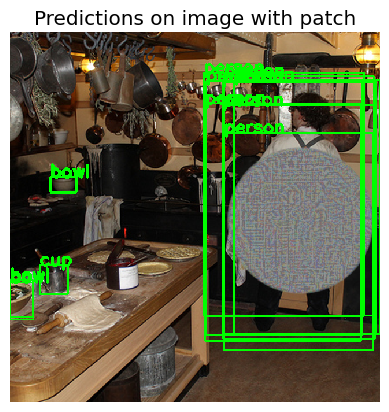

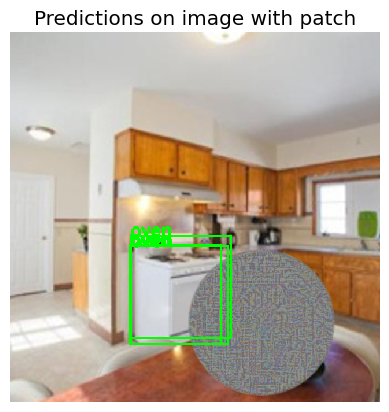

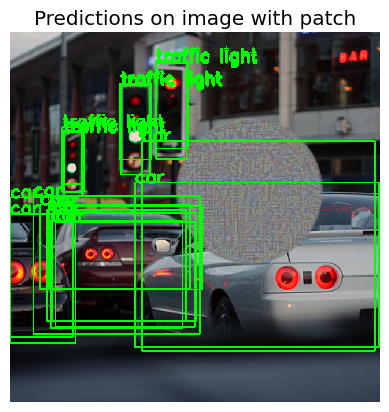

In [28]:
patched_images = ap.apply_patch(coco_images[:-1], scale=0.4)
dets = detector.predict(patched_images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.5)
    plot_image_with_boxes(img=patched_images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0],
                           title="Predictions on image with patch")
